In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, utils
from torchvision.datasets import FashionMNIST
from einops import rearrange

In [2]:
def get_mnist_loader(batch_size=256, shuffle=True):
    """

    :return: train_loader, test_loader
    """
    train_dataset = FashionMNIST(root='data',
                          train=True,
                          transform=torchvision.transforms.ToTensor(),
                          download=True)
    test_dataset = FashionMNIST(root='data',
                         train=False,
                         transform=torchvision.transforms.ToTensor(),
                         download=True)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=shuffle)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)
    return train_loader, test_loader

In [3]:
from einops import rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
             nn.Linear(dim, 2048), nn.GELU(), nn.Dropout(0.1), # Gaussian Error Linear Units is another type of activation function
            nn.Linear(2048, 1024), nn.GELU(), nn.Dropout(0.1),
            nn.Linear(1024, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [11]:
import torch.nn.functional as F


def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [12]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    # We do not need to remember the gradients when testing
    # This will help reduce memory
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            target = target.cuda()
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [28]:
import time

# You can change the architecture here
model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=32, depth=8, heads=8, mlp_dim=256)
model = model.cuda()
# We also print the network architecture
model

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_history, test_loss_history = [], []

In [29]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
ViT                                                     576
├─Linear: 1-1                                           1,600
├─Transformer: 1-2                                      --
│    └─ModuleList: 2-1                                  --
│    │    └─ModuleList: 3-1                             20,928
│    │    └─ModuleList: 3-2                             20,928
│    │    └─ModuleList: 3-3                             20,928
│    │    └─ModuleList: 3-4                             20,928
│    │    └─ModuleList: 3-5                             20,928
│    │    └─ModuleList: 3-6                             20,928
│    │    └─ModuleList: 3-7                             20,928
│    │    └─ModuleList: 3-8                             20,928
├─Identity: 1-3                                         --
├─Sequential: 1-4                                       --
│    └─Linear: 2-2                                      67,584
│    └─GELU

In [15]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [30]:
N_EPOCHS = 15

train_loader, test_loader = get_mnist_loader(batch_size=128, shuffle=True)

# Gradually reduce the learning rate while training
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

start_time = time.time()
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch,'LR:', scheduler.get_last_lr())
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)
    scheduler.step()

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1 LR: [0.001]
[    0/60000 (  0%)]  Loss: 2.3070
[12800/60000 ( 21%)]  Loss: 0.9579
[25600/60000 ( 43%)]  Loss: 0.8376
[38400/60000 ( 64%)]  Loss: 0.6302
[51200/60000 ( 85%)]  Loss: 0.5529

Average test loss: 0.6424  Accuracy: 7579/10000 (75.79%)

Epoch: 2 LR: [0.00095]
[    0/60000 (  0%)]  Loss: 0.4553
[12800/60000 ( 21%)]  Loss: 0.4344
[25600/60000 ( 43%)]  Loss: 0.4955
[38400/60000 ( 64%)]  Loss: 0.6294
[51200/60000 ( 85%)]  Loss: 0.4909

Average test loss: 0.4992  Accuracy: 8151/10000 (81.51%)

Epoch: 3 LR: [0.0009025]
[    0/60000 (  0%)]  Loss: 0.4775
[12800/60000 ( 21%)]  Loss: 0.3884
[25600/60000 ( 43%)]  Loss: 0.3538
[38400/60000 ( 64%)]  Loss: 0.4996
[51200/60000 ( 85%)]  Loss: 0.4261

Average test loss: 0.4541  Accuracy: 8351/10000 (83.51%)

Epoch: 4 LR: [0.000857375]
[    0/60000 (  0%)]  Loss: 0.2441
[12800/60000 ( 21%)]  Loss: 0.4304
[25600/60000 ( 43%)]  Loss: 0.4057
[38400/60000 ( 64%)]  Loss: 0.3480
[51200/60000 ( 85%)]  Loss: 0.4429

Average test loss: 0.4253 

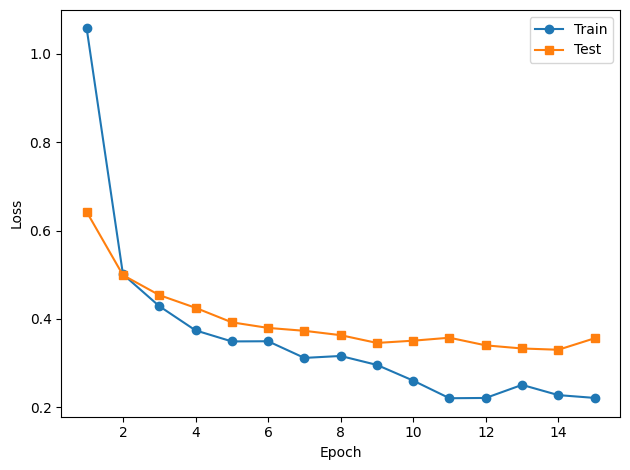

In [31]:
arr = np.asarray(train_loss_history, dtype=float)
chunks = np.array_split(arr, N_EPOCHS)                 # auto-splits 80 into ~equal pieces
train_loss_per_epoch = np.array([c.mean() for c in chunks])

test_loss_per_epoch  = np.asarray(test_loss_history)[:len(train_loss_per_epoch)]
epochs = np.arange(1, len(train_loss_per_epoch)+1)
plt.plot(epochs, train_loss_per_epoch, marker='o', label='Train')
plt.plot(epochs, test_loss_per_epoch,  marker='s', label='Test')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.tight_layout(); plt.show()
